In [1]:
from fyp.twitter_api import twitter_api, convert_datetime_to_ISO_8601, ratelimit_wait
from fyp.db import User, UserInteractorRelationships, Database, db
import matplotlib.pyplot as plt
from fyp.crypto import Crypto
from tqdm import tqdm
import numpy as np
import datetime
import time
import pandas as pd
import json
import os



In [2]:
from fyp.secrets import SECRETS
headers = {"Authorization": f"Bearer {SECRETS.TWITTER_BEARER_TOKEN}"}


In [3]:
def save_data(data, name):
    base = "/its/home/ep396/Documents/FYP/data/snowball/"
    e = base + f"encrypted_{name}.json"
    d = base + f"decrypted_{name}.json"

    with open(d, "w", encoding="utf8") as outfile:
        json.dump(data, outfile, indent=4, ensure_ascii=False)

    crypto.age_encrypt_file(d, e)

    os.remove(d)

In [10]:
def load_data(name):
    base = "/its/home/ep396/Documents/FYP/data/snowball/"
    e = base + f"encrypted_{name}.json"
    d = base + f"decrypted_{name}.json"

    crypto.age_decrypt_file(e, d)

    file = open(d, encoding='utf8')
    data = json.load(file)
    file.close()

    os.remove(d)

    return data


In [5]:
start_hop = 0
crypto = Crypto()
database = Database(crypto)


In [6]:
# Get seed users from db
users = {
    int(crypto.fernet_decrypt(user.twitter_user_id)):user.id
    for user in User.select(User.id, User.twitter_user_id).where(User.hop == start_hop and User.seed == True)
}

user_reverse = {value: key for key, value in users.items()}
user_twitter_ids = [user for user in users.keys()]


In [7]:
raw_timeframe = (datetime.datetime(2021, 1, 1, 0, 0, 0), datetime.datetime(2021, 12, 31, 23, 59, 59))
timeframe = tuple([convert_datetime_to_ISO_8601(timeframe) for timeframe in raw_timeframe])


In [8]:
base_seed_user_query = (
    '("trans" OR "enby" OR "transgender" OR "nonbinary" OR ' + 
    '"genderist" OR "genderism" OR "gender cult" OR ' + 
    '"adult human female" OR "#SexNotGender" OR ' +
    '"#IStandWithJKRowling" OR "#SexMatters" OR ' +
    '"#BiologyNotBigotry" OR "#WarOnWomen" OR ' +
    '"#IStandWithJKR" OR "Gender Critical" OR ' +
    '"#IStandWithMayaForstater") REPLACEME -"eng trans" '+
    '-"#transporn" -"#porn" -is:nullcast ' +
    'lang:en -is:retweet'
)


In [7]:
tweets = {}


In [8]:
def get_user_tweets(user_id, base_query):
    query = base_query.replace("REPLACEME", f"from:{user_id}")
    concat_data, next_token, cont = [], None, True
    start, end = timeframe

    while cont:
        params = {
            "query": query,
            "next_token": next_token,
            "start_time": start,
            "end_time": end,
            "tweet.fields": "public_metrics,conversation_id,referenced_tweets,reply_settings,in_reply_to_user_id,created_at",
            "expansions": "author_id",
            "max_results": 500,
        }

        data, limit_remaining_requests, limit_reset_time = twitter_api(
            url="https://api.twitter.com/2/tweets/search/all",
            headers=headers,
            params=params,
            data_location="data",
        )

        if data["fyp"]["error"] is True:
            if limit_remaining_requests <= 0 and cont is True:
                ratelimit_wait(limit_reset_time, "tweets", len(concat_data))
            else:
                raise Exception(data)
        else:
            concat_data += data["data"]
            print(f"Added: {len(data['data'])}")
            print(f"Total: {len(concat_data)}\n")
            next_token = (
                data["meta"]["next_token"]
                if "next_token" in data["meta"]
                else None
            )

            if next_token is None and data["fyp"]["error"] is False:
                cont = False

            time.sleep(1.05)

    return concat_data


In [9]:
# Loop through seed users, get relevant tweet IDs of a timespan of a year
for idx, pair in enumerate(users.items()):
    user_twitter_id, user_db_id = pair
    print(f"==> User {idx}")
    tweets[user_twitter_id] = get_user_tweets(user_twitter_id, base_seed_user_query)


==> User 0
Added: 500
Total: 500

Added: 102
Total: 602

==> User 1
Added: 335
Total: 335

==> User 2
Added: 182
Total: 182

==> User 3
Added: 280
Total: 280

==> User 4
Added: 251
Total: 251

==> User 5
Added: 500
Total: 500

Added: 408
Total: 908

==> User 6
Added: 169
Total: 169

==> User 7
Added: 95
Total: 95

==> User 8
Added: 220
Total: 220

==> User 9
Added: 500
Total: 500

Added: 500
Total: 1000

Added: 37
Total: 1037

==> User 10
Added: 500
Total: 500

Added: 126
Total: 626

==> User 11
Added: 252
Total: 252

==> User 12
Added: 500
Total: 500

Added: 500
Total: 1000

Added: 88
Total: 1088

==> User 13
Added: 500
Total: 500

Added: 500
Total: 1000

Added: 36
Total: 1036

==> User 14
Added: 160
Total: 160

==> User 15
Added: 163
Total: 163

==> User 16
Added: 163
Total: 163

==> User 17
Added: 500
Total: 500

Added: 500
Total: 1000

Added: 56
Total: 1056

==> User 18
Added: 237
Total: 237

==> User 19
Added: 500
Total: 500

Added: 152
Total: 652

==> User 20
Added: 500
Total: 50

In [72]:
save_data(tweets, "tweets")


In [11]:
def get_top_tweets_naive(user_twitter_ids, tweets, cap):
    best_user_tweets = {}
    for user in user_twitter_ids:
        user_tweets = tweets[user]
        user_tweets_sums = []

        for tweet in user_tweets:
            tweet_metrics = tweet["public_metrics"]
            metric_sum = sum([metric for metric in tweet_metrics.values()])
            user_tweets_sums.append((tweet['id'], metric_sum, tweet_metrics))
        
        user_tweets_sums.sort(key=lambda y: y[1], reverse=True)
        best_user_tweets[user] = user_tweets_sums[:cap]
    
    return best_user_tweets



In [12]:
cap = 10
f"{(((sum([len(tweet_cluster) if len(tweet_cluster) <= cap else cap for tweet_cluster in tweets.values()]) / 75) * 15) / 60)} hours"


'1.0 hours'

In [13]:
top_user_tweets = get_top_tweets_naive(user_twitter_ids, tweets, cap)


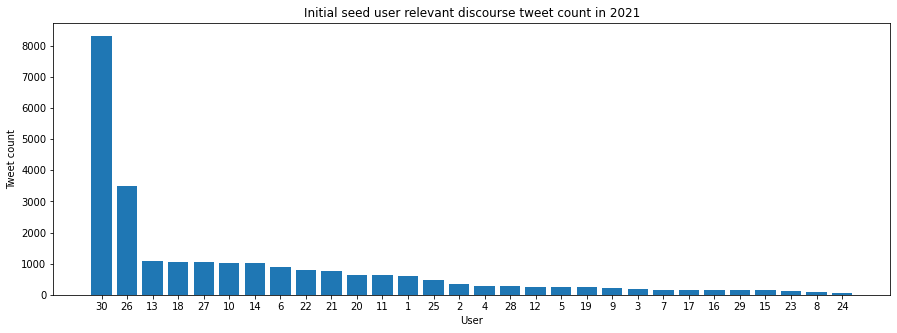

In [14]:
# Tweet count
tweet_counts = [(users[user_id], len(tweet_cluster)) for user_id, tweet_cluster in tweets.items()]

x = [str(counts[0]) for counts in tweet_counts]
y = [counts[1] for counts in tweet_counts]

df = pd.DataFrame({"User":x, "Tweet count":y})
df_sorted= df.sort_values('Tweet count', ascending=False)

plt.subplots(figsize=(15,5))

plt.title("Initial seed user relevant discourse tweet count in 2021")
plt.xlabel("User")
plt.ylabel("Tweet count")

plt.bar('User', 'Tweet count', data=df_sorted)
plt.show()

# Zipf's law :3


In [15]:
def user_id_to_usernames(best_users):
    url = "https://api.twitter.com/2/users"
    users = []

    ids_str = ""
    for id in best_users:
        ids_str += f"{id},"
    ids_str = ids_str[:-1]

    params = {
        "ids": ids_str,
        "user.fields": "username"
    }

    (
        user_data,
        limit_remaining_requests,
        limit_reset_time
    ) = twitter_api(headers=headers, url=url, params=params, data_location='data')

    if user_data["fyp"]["error"] == True:
        raise Exception(user_data)

    users += user_data["data"]
    time.sleep(1.05)

    return {int(user["id"]):user["username"] for user in users}


In [50]:
# user_id_to_usernames([user for user in users.keys()])

In [17]:
def get_tweet_retweeters(user_ids, top_user_tweets):
    retweeters = {}

    for user_idx, user in enumerate(user_ids):
        user_id = int(user)
        retweeters[user_id] = {}

        print(f"==> User {user_idx}")


        for hidden_idx, tweet in enumerate(top_user_tweets[user_id]):
            print(f"==> Tweet {hidden_idx}")
            if tweet[2]["retweet_count"] > 0 or tweet[2]["quote_count"] > 0:
                cont, concat_data = True, []
                params = {
                    "max_results": 100
                }
                url = f"https://api.twitter.com/2/tweets/{tweet[0]}/retweeted_by"

                while cont:
                    (
                        api_data, 
                        limit_remaining_requests, 
                        limit_reset_time
                    ) = twitter_api(headers=headers, url=url, params=params, data_location='data')

                    if api_data['fyp']['error']:
                        if limit_remaining_requests <= 0 and cont is True:
                            ratelimit_wait(limit_reset_time, 'users', len(concat_data))
                        elif api_data["meta"]["result_count"] == 0:
                            cont = False
                        else:
                            raise Exception(api_data)

                    else:
                        concat_data += api_data["data"]
                        print(f"Added: {len(api_data['data'])}")
                        print(f"Total: {len(concat_data)}\n")
                        params["pagination_token"] = api_data["meta"]["next_token"] if "next_token" in api_data["meta"] else None

                        if params["pagination_token"] is None and api_data["fyp"]["error"] is False:
                            cont = False

                        time.sleep(1.05)
                
                retweeters[user_id][int(tweet[0])] = concat_data

            else:
                print("None")
            
    return retweeters


In [18]:
def get_unique_retweeters(best_users, user_unique_retweeters):
    unique_retweeters = {}

    for user in best_users:
        user_id = int(user[0])
        retweeted_users = []
        for value in user_unique_retweeters[user_id].values():
            if value is not []:
                for idx in value:
                    if idx not in retweeted_users:
                        retweeted_users.append(idx)
        
        unique_retweeters[user_id] = retweeted_users

    return unique_retweeters


In [19]:
# retweeters
retweeters = get_tweet_retweeters([user for user in users.keys()], top_user_tweets)


==> User 0
==> Tweet 0
Added: 84
Total: 84

Added: 88
Total: 172

Added: 93
Total: 265

Added: 85
Total: 350

Added: 87
Total: 437

Added: 12
Total: 449

==> Tweet 1
Added: 89
Total: 89

==> Tweet 2
Added: 81
Total: 81

==> Tweet 3
Added: 46
Total: 46

==> Tweet 4
Added: 33
Total: 33

==> Tweet 5
Added: 66
Total: 66

==> Tweet 6
None
==> Tweet 7
Added: 49
Total: 49

==> Tweet 8
Added: 36
Total: 36

==> Tweet 9
Added: 10
Total: 10

==> User 1
==> Tweet 0
Added: 87
Total: 87

Added: 82
Total: 169

Added: 82
Total: 251

Added: 85
Total: 336

Added: 88
Total: 424

Added: 91
Total: 515

Added: 90
Total: 605

Added: 89
Total: 694

Added: 84
Total: 778

Added: 87
Total: 865

Added: 86
Total: 951

Added: 85
Total: 1036

Added: 86
Total: 1122

Added: 91
Total: 1213

Added: 86
Total: 1299

Added: 86
Total: 1385

Added: 85
Total: 1470

Added: 76
Total: 1546

Added: 85
Total: 1631

Added: 83
Total: 1714

Added: 81
Total: 1795

Added: 88
Total: 1883

Added: 87
Total: 1970

Added: 87
Total: 2057

Ad

In [73]:
# Save tweet data and encrypt
save_data(retweeters, "retweeters_10")


In [58]:
def get_unique_retweeters(users, user_unique_retweeters):
    unique_users = []
    relations = {}

    for user in users:
        tweets = user_unique_retweeters[user]
        relations[user] = []
        for captured_users in tweets.values():
            for captured_user in captured_users:
                captured_user_id = captured_user["id"]
                if captured_user_id not in unique_users: unique_users.append(captured_user_id)
                if captured_user_id not in relations[user]: relations[user].append(captured_user_id)

    return unique_users, relations



In [59]:
unique_retweeters, unique_retweeters_relations = get_unique_retweeters(user_twitter_ids, retweeters)
unique_repliers = {}


In [66]:
len(unique_retweeters)

135181

In [65]:
sum([len(user_relation) for user_relation in unique_retweeters_relations.values()])


173290

In [74]:
save_data(unique_retweeters, "unique_retweeters")
save_data(unique_retweeters_relations, "unique_retweeters_relations")



In [11]:
unique_retweeters = load_data("unique_retweeters")
unique_retweeters_relations = load_data("unique_retweeters_relations")


In [ ]:
if database.encrypted():
    database.encrypt_or_decrypt()

for user in tqdm(unique_retweeters):
    database.add_user(user, True, 1)

if not database.encrypted():
    database.encrypt_or_decrypt()


In [ ]:
if database.encrypted():
    database.encrypt_or_decrypt()

for user, interactors in tqdm(unique_retweeters_relations.items()):
    for interactor in interactors:
        database.add_relation(user, interactor)

if not database.encrypted():
    database.encrypt_or_decrypt()


In [21]:
# repliers
repliers = {}


In [23]:
unique_tweet_interaction_users = {}
